# Cooperation requires mutual interaction

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sim_wc
from params_4_Cooperation import params
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import tools_wc
import copy
import matplotlib as mpl
plt.rc('text', usetex = True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb}'
plt.rc('font', **{'family': 'serif', 'size': 20})
plt.rcParams.update({'font.size': 20})
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import tools_plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
t = params['t']

fname_res = 'data/4_r_cooperation.pckl'

In [3]:
load_res = True

if load_res:
    r = tools_wc.load_pckl(fname_res)
    
else:

    r = np.zeros([
        len(params['range_pot_pairing0']),
        len(params['range_pot_pairing1']),
        len(t),
        len(np.concatenate(params['seqs']))*2,
        ])

    for i, pot_pr_0 in enumerate(tqdm(params['range_pot_pairing0'])):
        for j, pot_pr_1 in enumerate(params['range_pot_pairing1']):
            sim = sim_wc.Simulator(params)
            sim.set_interaction_matrix()
            # pair sequences
            sim.pair_sequences(
                pos_sender=1,
                pos_target=2,
                pot=pot_pr_0,
                type_proj=params['type_proj'],
                delta_assembly=params['delta_assembly'])
            sim.pair_sequences(
                pos_sender=2,
                pos_target=1,
                pot=pot_pr_1,
                type_proj=params['type_proj'],
                delta_assembly=params['delta_assembly'])
            _, r_ij = sim.run()
            r[i, j, :, :] = r_ij.T
    tools_wc.save_pckl(r, fname_res)

In [4]:
rE = r[:, :, :, ::2]

crit = np.zeros([
    len(params['range_pot_pairing0']),
    len(params['range_pot_pairing1']),
    len(params['seqs'])
], dtype=bool)

dt = np.mean(np.unique(np.diff(params['t'])))

for i in tqdm(range(len(params['range_pot_pairing0']))):
    for j in range(len(params['range_pot_pairing1'])):
        for m, seq_m in enumerate(params['seqs']):
            rE_ijm = rE[i, j, :, :][:, seq_m]  
            seq_m_pos = seq_m - seq_m[0]
            crit[i, j, m] = tools_wc.peak_criterium(rE_ijm, params['r_min'], seq_m_pos, params['tol'])

100%|███████████████████████████████████████████████████████████████████| 40/40 [01:26<00:00,  2.15s/it]


In [5]:
crit_12lumped = np.zeros([
    len(params['range_pot_pairing0']),
    len(params['range_pot_pairing1']),
    2
], dtype=bool)

In [6]:
crit_12lumped[:,:,0] = crit[:,:,0]
crit_12lumped[:,:,1] = np.logical_and(crit[:,:,1], crit[:,:,2])

In [43]:
cmap = mpl.cm.get_cmap('Greys')

cmaplist = [cmap(i) for i in range(cmap.N)]
alpha_adjusted = 0.5  # You can set this to a value between 0 (fully transparent) and 1 (fully opaque)
cmaplist = [(r, g, b, alpha_adjusted) for r, g, b, _ in cmaplist]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = [0, 0.9, 1.1, 2.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [44]:
ar_examples = np.array([
    [1.2e-2, 1.2e-2],
    [1.7e-2, 1.7e-2],
    [2.3e-2, 2.3e-2],
    [3e-2, 3e-2],

]) # x, y

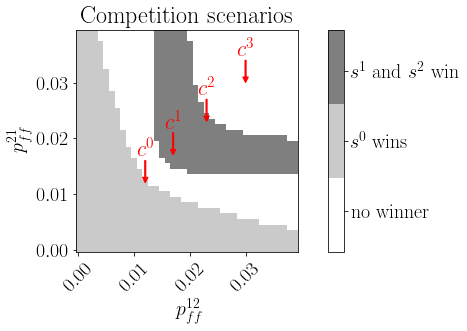

In [45]:
piv = np.sum(crit_12lumped, axis=2)
f = 0.1
piv = piv - f*crit_12lumped[:, :, 0]
piv = piv + f*crit_12lumped[:, :, 1]

fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(7,5))


ax[0,0].set_ylabel(r'$p^{21}_{ff}$')
ax[0,0].set_xlabel(r'$p^{12}_{ff}$')
ax[0,0].set_title(r'Competition scenarios')


ax[0,0].set_aspect('equal')


X, Y = np.meshgrid(
    params['range_pot_pairing0']*params['p_ff'],
    params['range_pot_pairing1']*params['p_ff'])
heatmap = ax[0,0].pcolormesh(
    X,
    Y,
    piv, cmap=cmap, norm=norm)

ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


ax2 = ax[0, 1]

cb = mpl.colorbar.ColorbarBase(
    ax2, cmap=cmap, norm=norm,
    #spacing='proportional',
    #ticks=[0.5, 1., 1.5, 2.5],
    ticks=[0.5, 1., 1.5],
    boundaries=bounds[:-1], format='%2i')
cb.ax.set_yticklabels(
    ['no winner',
     '$s^0$ wins',
     '$s^1$ and $s^2$ win'])

# draw arrows
dx, dy = 0, -3e-3
head_length = 1e-3
for i, ex_i in enumerate(ar_examples):
    p__12_ff_i, p__21_ff_i = ex_i
    ax[0,0].arrow(
        p__12_ff_i-dx, p__21_ff_i-dy+head_length,
        dx, dy,
        color='r',
        width=2e-4,
        head_width=1e-3,
        head_length=1e-3)

    ax[0,0].text(
        p__12_ff_i, p__21_ff_i+4e-3,
        #r'$\stackrel$',
        #r'$*^{s^'+str(i)+'}$',
        r'$c^'+str(i)+'$',
             color='r', fontsize=22,
        horizontalalignment='center',
        verticalalignment='bottom')

fig.tight_layout()

fig.savefig('figures/4b_CooperationRequiresMutualInteractions.svg')

## Activities of examples 

In [38]:
ls_title = [
    r'$c^0:s^1 - s^2$',
    r'$c^1:s^1 \leftrightarrow s^2$',
    r'$c^2:s^1 \Leftrightarrow s^2$',
    r'$c^3:s^1 \Longleftrightarrow s^2$',
]

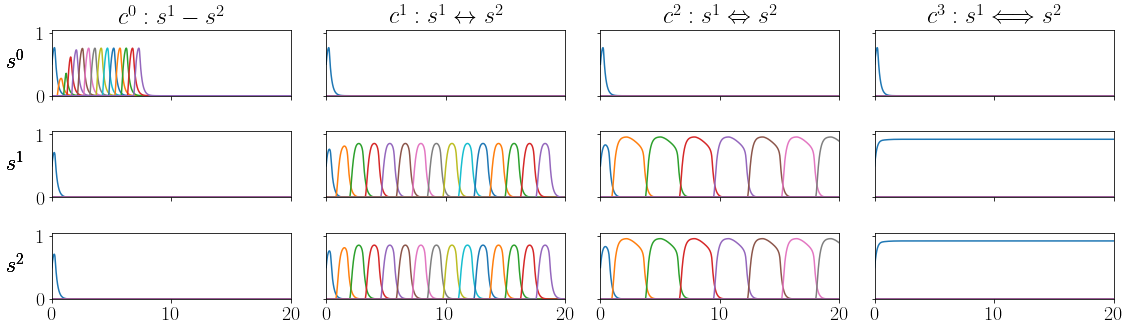

In [39]:
fig, ax = plt.subplots(
    len(params['seqs']),
    len(ar_examples),
    sharex=True, sharey=True,
    figsize=(16, 5)
)

ax[0, 0].set_ylim(0, 1.05)
ax[0, 0].set_xlim(0, 20.)

for i, ex_i in enumerate(ar_examples):
    p__12_ff_i, p__21_ff_i = ex_i
    idx_p__12_ff_i = np.where(
        np.abs(params['range_pot_pairing0']*params['p_ff']-p__12_ff_i)<1e-10
        )[0][0]
    idx_p__21_ff_i = np.where(
        np.abs(params['range_pot_pairing1']*params['p_ff']-p__21_ff_i)<1e-10
        )[0][0]

    ax[0, i].set_title(ls_title[i])
    for j, seq_j in enumerate(params['seqs']):
        ax[j, 0].text(
            -0.15, 0.5,
            r'$s^'+str(j)+'$',
            fontsize=22, rotation=0,
            va='center', ha='center',
            transform=ax[j, 0].transAxes)

        for idx_ass_ex_j in seq_j[::2]:
            ax[j, i].plot(
                params['t'],
                rE[idx_p__12_ff_i, idx_p__21_ff_i, :, idx_ass_ex_j])
fig.tight_layout()
fig.savefig('figures/4c_Examples.svg')

## Mean activation time

In [12]:
n_i = len(params['range_pot_pairing0'])
n_j = len(params['range_pot_pairing1'])

ar_mean_act_time = np.empty((n_i, n_j), dtype=float)
dt = np.round(np.median(np.diff(params['t'])),4)
seq = params['seqs'][1]

for i in range(n_i):
    for j in range(n_j):
        r_ij = rE[i, j, :, seq].T
        ar_mean_act_time[i, j] = tools_wc.mean_activation_time(r_ij, params['r_min'], dt)

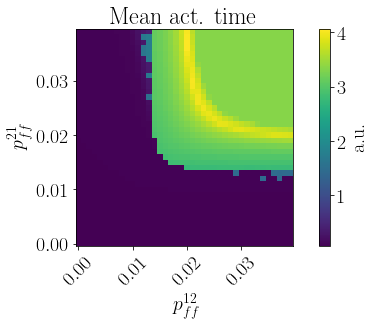

In [51]:
fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(4.6,4))

ax[0,0].set_ylabel(r'$p^{21}_{ff}$')
ax[0,0].set_xlabel(r'$p^{12}_{ff}$')
ax[0,0].set_title(r'Mean act. time')


ax[0,0].set_aspect('equal')
heatmap = ax[0,0].pcolormesh(
    params['range_pot_pairing0']*params['p_ff'],
    params['range_pot_pairing1']*params['p_ff'],
    ar_mean_act_time.T)

ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


cb = fig.colorbar(heatmap, cax=ax[0,1])
ax[0,1].set_ylabel('a.u.')

fig.savefig('figures/4d_mean_activation_time.svg')

## Ratio of activated assemblies

In [14]:
n_i = len(params['range_pot_pairing0'])
n_j = len(params['range_pot_pairing1'])

ar_n_active = np.empty((n_i, n_j), dtype=float)
dt = np.round(np.median(np.diff(params['t'])),4)
seq = params['seqs'][1]

for i in range(n_i):
    for j in range(n_j):
        r_ij = rE[i, j, :, seq].T
        ar_n_active[i, j] = tools_wc.number_active(r_ij, params['r_min'])
        
ar_ratio_active = ar_n_active/len(seq)

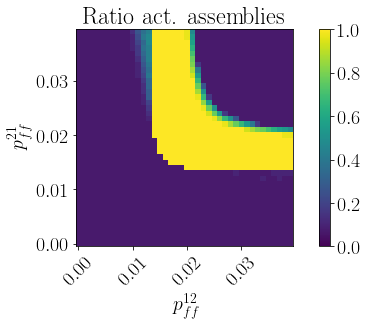

In [50]:
fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(4.6,4))

ax[0,0].set_ylabel(r'$p^{21}_{ff}$')
ax[0,0].set_xlabel(r'$p^{12}_{ff}$')
ax[0,0].set_title(r'Ratio act. assemblies')


ax[0,0].set_aspect('equal')
heatmap = ax[0,0].pcolormesh(
    params['range_pot_pairing0']*params['p_ff'],
    params['range_pot_pairing1']*params['p_ff'],
    ar_ratio_active.T,
    vmin=0)

ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


cb = fig.colorbar(heatmap, cax=ax[0,1])

fig.savefig('figures/4e_ratio_active.svg')

In [16]:
np.median(ar_ratio_active)

0.06666666666666667

## Activation time of first assembly

In [17]:
n_i = len(params['range_pot_pairing0'])
n_j = len(params['range_pot_pairing1'])

ar_act_time_first = np.empty((n_i, n_j), dtype=float)
dt = np.round(np.median(np.diff(params['t'])),4)
seq = params['seqs'][1]

for i in range(n_i):
    for j in range(n_j):
        r_ij = rE[i, j, :, seq[0,]].T
        ar_act_time_first[i, j] = tools_wc.mean_activation_time(r_ij, params['r_min'], dt)

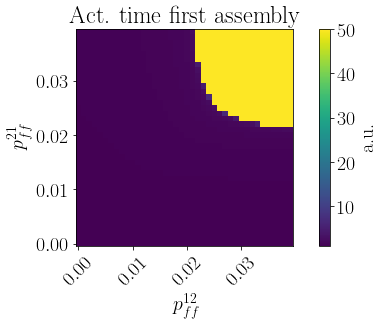

In [48]:
fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(4.6,4))

ax[0,0].set_ylabel(r'$p^{21}_{ff}$')
ax[0,0].set_xlabel(r'$p^{12}_{ff}$')
ax[0,0].set_title(r'Act. time first assembly ')


ax[0,0].set_aspect('equal')
heatmap = ax[0,0].pcolormesh(
    params['range_pot_pairing0']*params['p_ff'],
    params['range_pot_pairing1']*params['p_ff'],
    ar_act_time_first.T)

ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


cb = fig.colorbar(heatmap, cax=ax[0,1])
ax[0,1].set_ylabel('a.u.')

fig.savefig('figures/4f_activationtimefirstassembly.svg')

### Speed of reference sequence

In [1]:
seq = params['seqs'][0]

p_ff_i, p_ff_j = ar_examples[0]

idx_p_ff_i = np.where(
    np.abs(params['range_pot_pairing0']*params['p_ff']-p_ff_i)<1e-10
    )[0][0]
idx_p_ff_j = np.where(
    np.abs(params['range_pot_pairing1']*params['p_ff']-p_ff_j)<1e-10
    )[0][0]

dt = np.round(np.median(np.diff(params['t'])),4)

r_ij = rE[idx_p_ff_i, idx_p_ff_j, :, seq].T

seq_speed_i = tools_wc.sequence_speed(r_ij, params['r_min'], params['tol'], dt)

NameError: name 'params' is not defined

In [21]:
seq_speed_i

3.846153846153846